In [26]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.preprocessing

# Define the sign function
def sign(x):
    return 0 if x < 0 else 1

## Normalization

Before we look to nonlinearly separable data, let's look at the normalization. During normalization, we standardize each datapoint, si it's vector have length 1. We can do that simply by deviding it by the length of the vector itself.

$$
\pmb{w_{norm}} = \frac{\pmb{w}}{|\pmb{w}|}=\frac{\pmb{w}}{\sqrt{\sum_i^D w_i^2}}
$$ 

Note, that this modification doesn't change the solution, as the hyperplane separating the original data separates the normalized data as well. For example let's look at the example from the previous notebook.

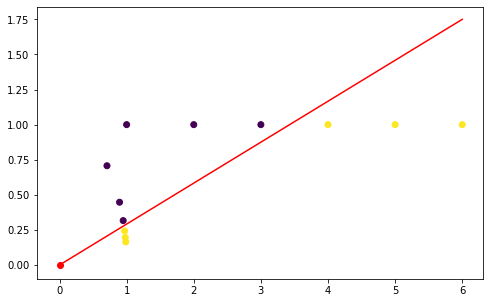

In [27]:
data = np.array([[1,1],[2,1],[3,1],[4,1],[5,1],[6,1]])
classes = np.array([0,0,0,1,1,1])
lengths = np.sqrt((data * data).sum(axis=1))
data_normalized = data / lengths[:,None]
plt.figure(figsize=(8,5))
plt.scatter(data[:,0],data[:,1], c = classes)
plt.scatter(data_normalized[:,0], data_normalized[:,1], c=classes)
plt.scatter(0,0,c='r')
plt.plot([0,6],[0,1.75], c='r')
plt.show()

By using normalization, all the data points' vectors will have length equal to one, so all the data points will influence the norm of the separating hyperplane only by it's angle, not based on it's length. In the result, each of the datapoint will influence the norm by the same "strength". 

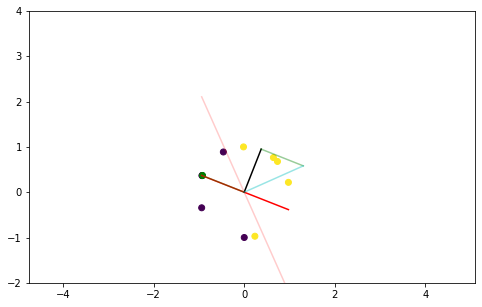

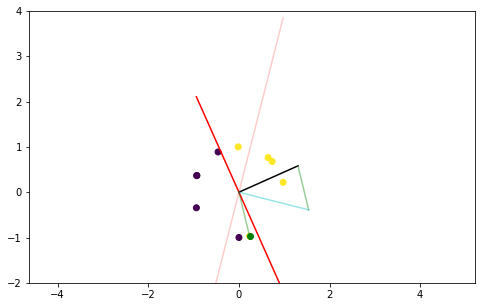

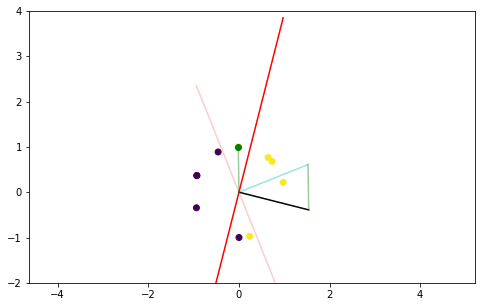

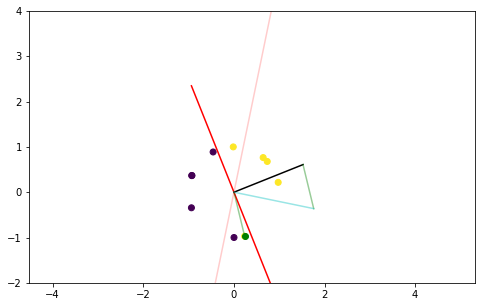

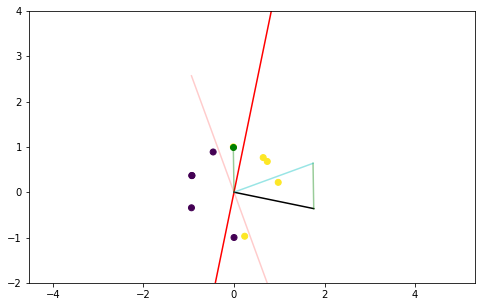

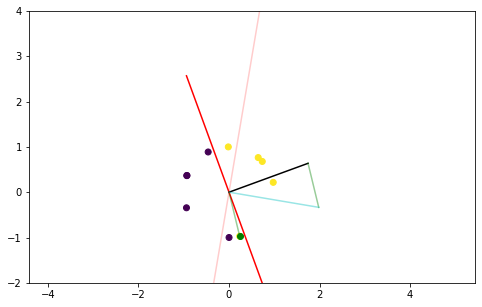

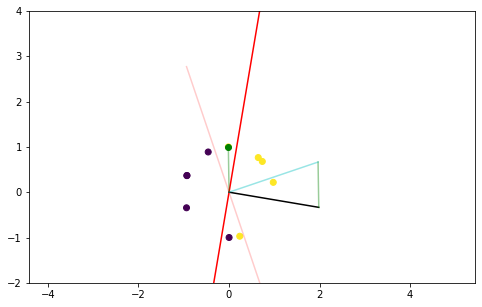

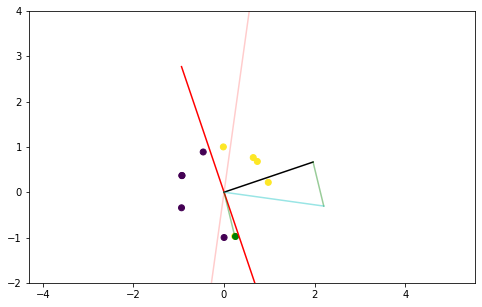

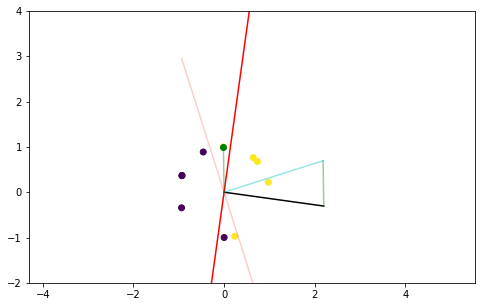

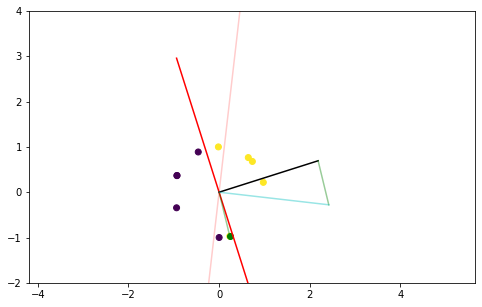

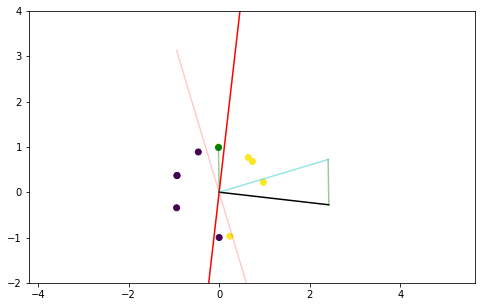

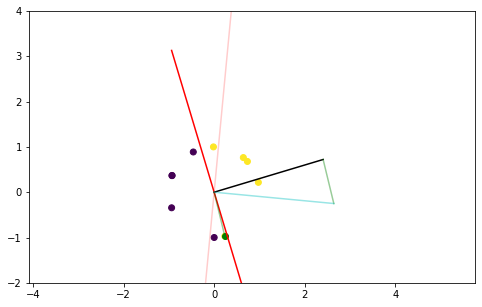

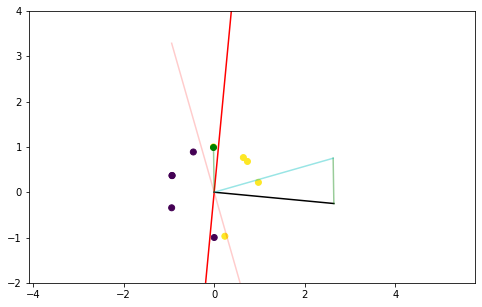

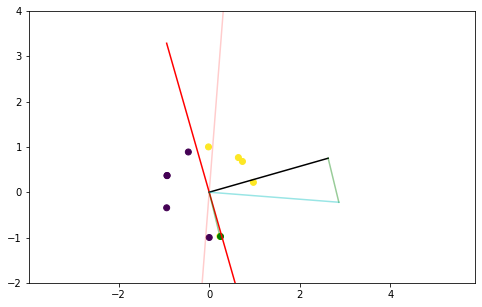

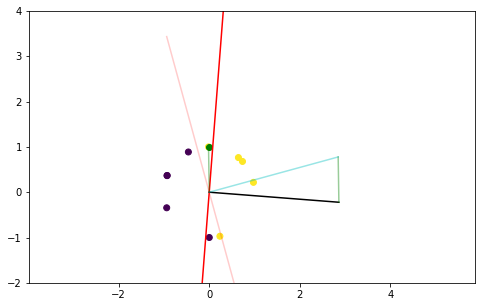

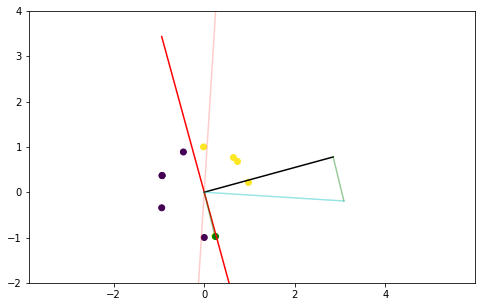

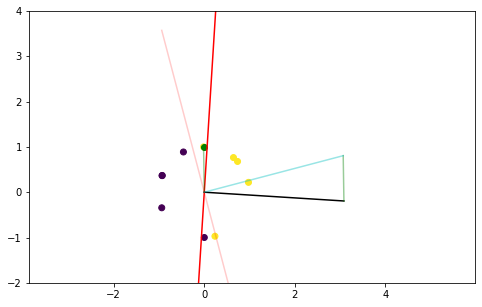

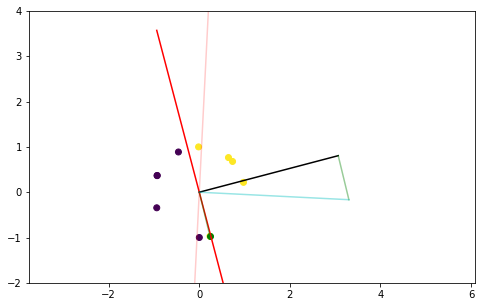

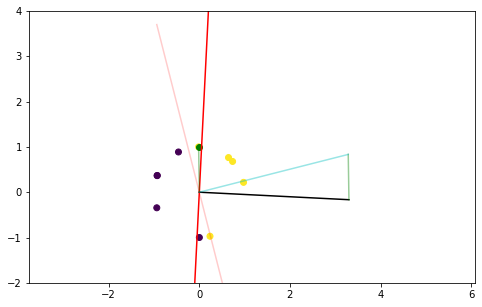

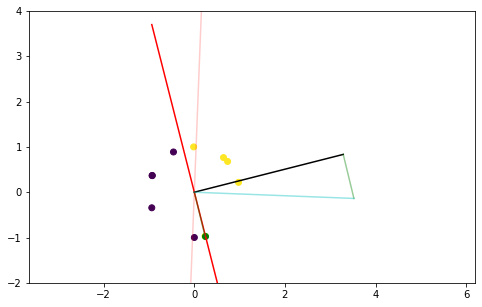

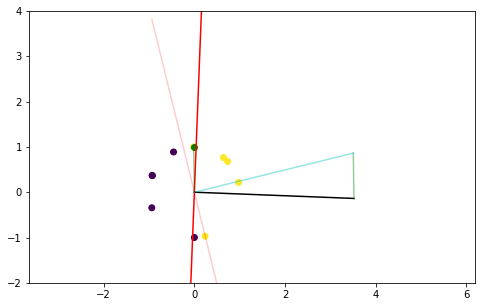

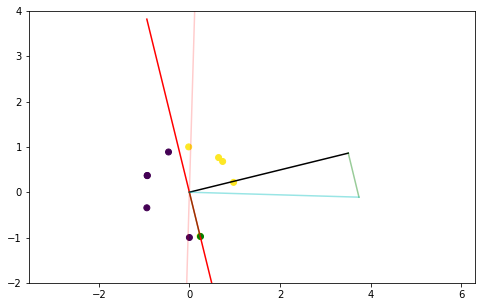

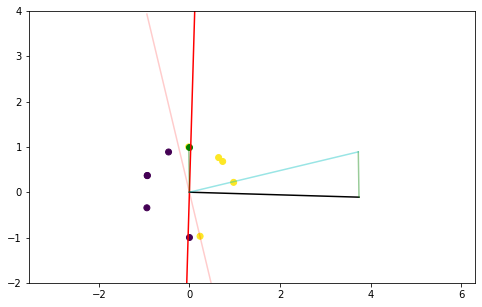

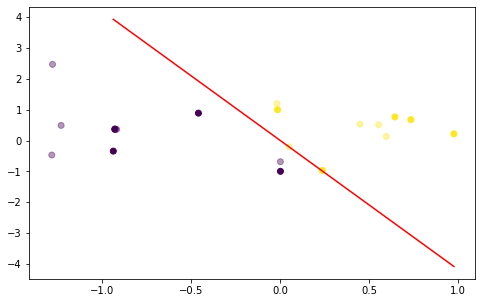

In [40]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=10, 
    n_features=2, 
    centers=[[-1,0.4],[1,0.6]], 
    cluster_std=0.8, 
    random_state=51
)
data_norm = sklearn.preprocessing.normalize(data)

# PERCEPTRON TRAINING
# Initialize the weights
weights = np.random.RandomState(42).uniform(size=2)

# Iterate until convergence
weights_changed = True
while weights_changed:
    weights_changed = False
    # for every instance in the data
    for instance, target in zip(data_norm, classes):
        # predict the output of the perceptron
        prediction = sign(instance @ weights)
        # update the weights
        weights_new = weights + (target - prediction) * instance
        
        # plot the change
        if (weights != weights_new).any():
            slope = - weights[0] / weights[1]  # calculate the slope
            plt.figure(figsize=(8, 5))
            plt.plot(
                [data_norm.min(axis=0)[0], data_norm.max(0)[0]], 
                [slope * data_norm.min(axis=0)[0], slope * data_norm.max(axis=0)[0]], 
                c='r')  # plot the separating line
            plt.plot([0, weights[0]],[0, weights[1]], c='black')  # plot the norm
            plt.scatter(data_norm[:,0], data_norm[:,1], c=classes)  # plot the data
            plt.scatter(instance[0], instance[1], c='g')  # plot the missclassified instance
            plt.plot([0, instance[0]], [0, instance[1]], c='g', alpha=0.4)  # plot the instance vector
            plt.plot(
                [weights[0], weights[0] + (target - prediction) * instance[0]], 
                [weights[1], weights[1] + (target - prediction) * instance[1]],
                c='g', alpha=0.4)  # plot the instance vector from the normal
            plt.plot(
                [0, weights[0] + (target - prediction) * instance[0]], 
                [0, weights[1] + (target - prediction) * instance[1]], 
                c='c', alpha=0.4)  # plot new normal
            slope_new = - weights_new[0] / weights_new[1]  # calculate the slope of new line
            plt.plot(
                [data_norm.min(axis=0)[0], data_norm.max(0)[0]], 
                [slope_new * data_norm.min(axis=0)[0], slope_new * data_norm.max(axis=0)[0]], 
                c='r', alpha=0.2)  # plot the separating line
            plt.axis('equal')
            plt.ylim(-2,4)
            plt.show()
        
        weights_changed = weights_changed or (weights != weights_new).any()
        weights = weights_new
        
# PLOTTING THE FINAL WEIGHTS
slope = - weights[0] / weights[1]
plt.figure(figsize=(8, 5))
plt.scatter(data_norm[:,0], data_norm[:,1], c=classes)
plt.scatter(data[:,0], data[:,1], c=classes, alpha=0.4)
plt.plot(
    [data_norm.min(axis=0)[0], data_norm.max(0)[0]], 
    [slope * data_norm.min(axis=0)[0], slope * data_norm.max(axis=0)[0]], 
    c='r')
plt.show()

This example is extraordinary interesting. The line gets to state, where only the two points (the purple one on top and the yellow one on bottom) are sequentially missclassified. The algorithm always try to correct the error and move the hyperplane to correct way. As the norm size increase, the steps are getting smaller and smaller, until both data points are finally classified correctly.

# Nonlinearly separable data

What if we have nonlinearly separable data? As there will be always some datapoint, that would change the hyperplane, the perceptron algorithm never stops. We can limit the number of iterations, that the perceptron algorithm can perform. At the same time, I will introduce the **learning rate** constant to control the size of rotation.

Firstly, let's generate the data.

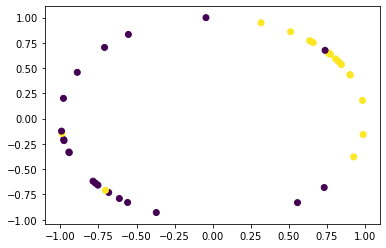

In [90]:
data_orig, classes = sklearn.datasets.make_blobs(
    n_samples=40,
    n_features=2,
    centers=([-1, -1], [1, 1]),
    cluster_std=(1.4, 0.8),
    random_state=49,
)
data = sklearn.preprocessing.normalize(data_orig)
plt.scatter(data[:,0], data[:,1], c=classes)
plt.show()

The points are nearly linearly separable, except one purple one and two yellow ones (if we allow bias). Note that data are already normalized - normalization always create hypersphere (that is circle in 2D) around the zero coordinate.

Now let's talk about the learning rate. During the training process, instead of moving the norm by the value of vector $\pmb{x}$, we will add (or subtract) only a fraction of the data point. That is, the update rule in the algorithm changes from $\pmb{w}=\pmb{w}+(target - prediction) \cdot \pmb{x}$ to $\pmb{w}=\pmb{w}+\alpha \cdot (target - prediction) \cdot \pmb{x}$ where $\alpha$ is the learning rate. We can set up constant learning rate - small value like $10^{-5}$ or we can use adaptive learning rate, that will decrease during the training. The formula for adaptive learning rate should satisfy following conditions (see [[1]](#Bibliography)).

$$
\lim_{t\to\infty}\alpha_t = 0; \sum_{t=1}^\infty \alpha_t=\infty; \sum_{t=1}^\infty \alpha_t^2 \lt \infty
$$

One possibility is to use $\alpha=\frac{1}{k}$ but from the practical point of view, the learning rate may decrease too fast. Another possibility is $\alpha=\frac{1}{\sqrt{k}}$, although it doesn't satisfy the second condition.

To keep updates decreasing, we must normalize the norm itself (after each update or after each iteration), so the size of update is kept same and doesn't depend on the size of the norm (but rather on the directions). Keep in mind that algorithm with this modification doesn't need to converge (for properly prepared data). Practically, if the data are trully random and the dataset is big enough (at least 50 datapoints), I wouldn't be afraid of this happen. We may decrease the probability even more by taking the data randomly at each iteration.

I will not rewrite the perceptron learning algorithm to use maximum of 10 iterations and learning rate $\alpha=\frac{1}{k}$.

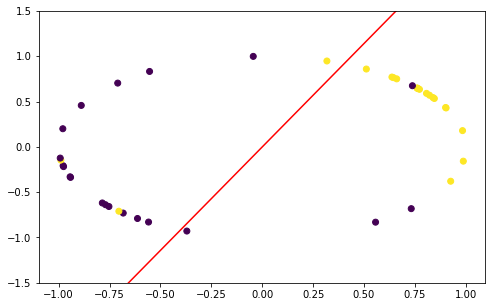

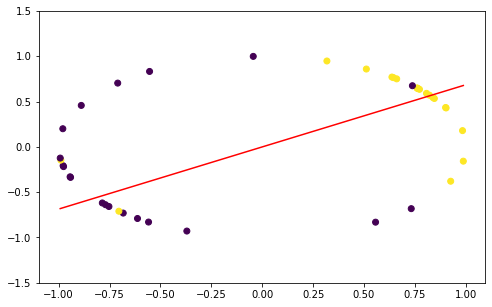

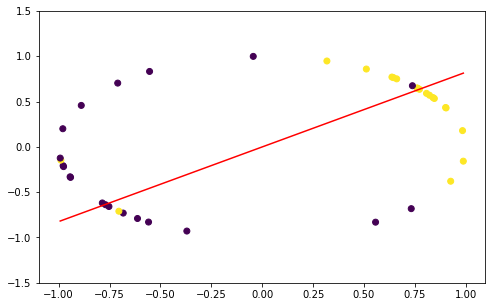

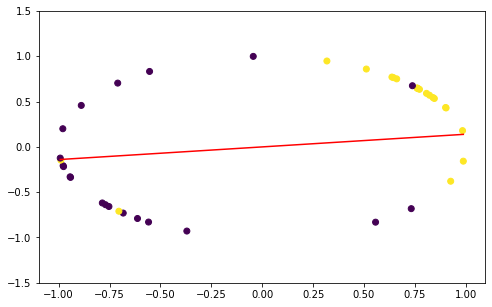

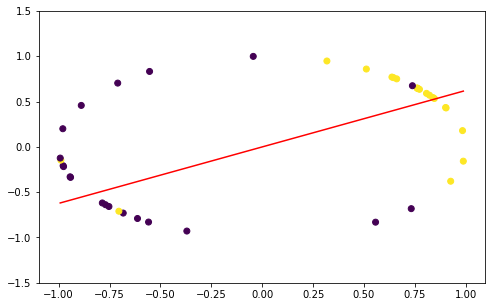

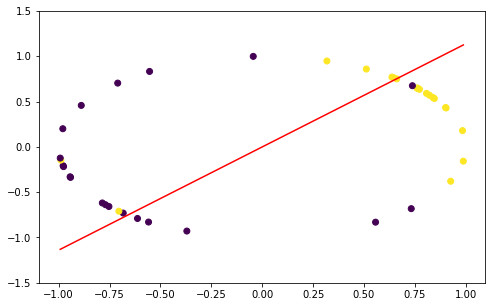

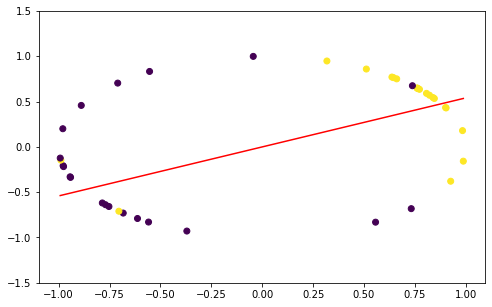

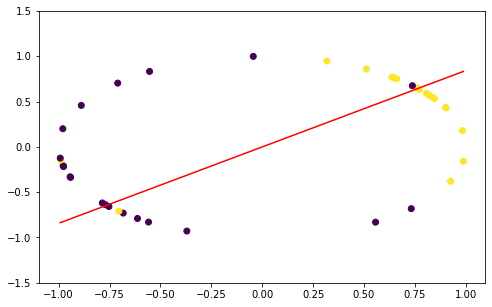

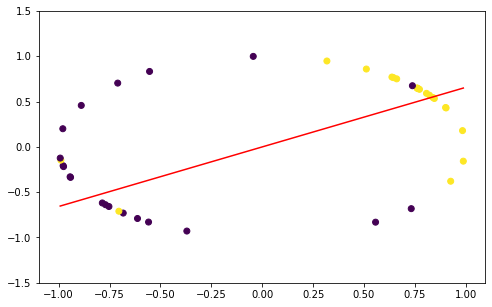

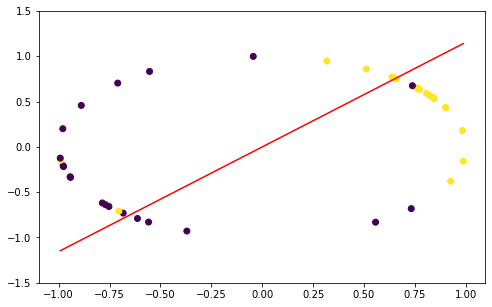

In [96]:
# Initialize the weights
rand = np.random.RandomState(42)
weights = rand.uniform(-2, 2, 2)

# Iterate until max iteration reaches
for iteration in range(1, 11): 
    # for every instance in the data
    for instance, target in zip(rand.permutation(data), classes):
        # predict the output of the perceptron
        prediction = sign(instance @ weights)
        # compute the learning rate
        learning_rate = 1 / iteration
        # update the weights
        weights  = weights + learning_rate * (target - prediction) * instance
        weights = weights / np.linalg.norm(weights)
    
    # Plot the hyperplane
    slope = - weights[0] / weights[1]
    plt.figure(figsize=(8, 5))
    plt.scatter(data[:,0], data[:,1], c=classes)
    plt.plot(
        [data.min(axis=0)[0], data.max(0)[0]], 
        [slope * data.min(axis=0)[0], slope * data.max(axis=0)[0]], 
        c='r')
    plt.ylim(-1.5,1.5)
    plt.show()

We may show the missclassified examples green.

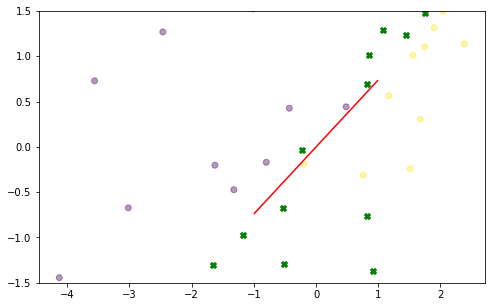

In [95]:
slope = - weights[0] / weights[1]
plt.figure(figsize=(8, 5))
wrong_data = classes != [sign(instance @ weights) for instance in data] # get missclassified data
correct_data = np.logical_not(wrong_data)
plt.scatter(data_orig[correct_data,0], data_orig[correct_data,1], c=classes[correct_data], alpha=0.4)
plt.scatter(data_orig[wrong_data,0], data_orig[wrong_data,1], marker='X', c='g') # plot missclassified data
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0], slope * data.max(axis=0)[0]], 
    c='r')
plt.ylim(-1.5,1.5)
plt.show()

# Bibliography

[1] A Stochastic Approximation Method, Herbert Robbins and Sutton Monro, 1951